In [1]:
import pandas as pd
import importlib
from datetime import date
import matplotlib.pyplot as plt

In [2]:
import modo_energy_client.modo_energy_api_client

importlib.reload(modo_energy_client.modo_energy_api_client)
from modo_energy_client.modo_energy_api_client import ModoEnergyAPIClient

client = ModoEnergyAPIClient(api_token="your_api_token_here")

In [4]:
ercot_bess = client.get_ercot_modo_owners(date_from="2023-01", date_to="2026-01")

Fetching pages : 0page [00:00, ?page/s]

In [5]:
# Group by the month of the 'date' column
ercot_bess["month"] = ercot_bess["date"].dt.to_period("M").dt.to_timestamp()
ercot_bess_monthly = (
    ercot_bess.groupby("month")
    .agg({"total_energy_capacity_mwh": "mean", "total_rated_power_mw": "mean"})
    .reset_index()
)
ercot_bess_monthly.head()

,month,total_energy_capacity_mwh,total_rated_power_mw
0,2023-01-01,113.945652,87.880435
1,2023-02-01,114.806522,88.741304
2,2023-03-01,114.806522,88.741304
3,2023-04-01,138.545652,97.436957
4,2023-05-01,147.154348,101.784783


In [46]:
fuel_mix = client.get_ercot_generation_fuel_mix(
    date_from=date(2023, 1, 1), date_to=date(2025, 12, 31)
)
fuel_mix = fuel_mix.drop(["settlementType", "repeated_hour_flag"], axis=1)

fuel_mix_monthly = fuel_mix.resample("ME").mean()

Fetching pages : 0page [00:00, ?page/s]

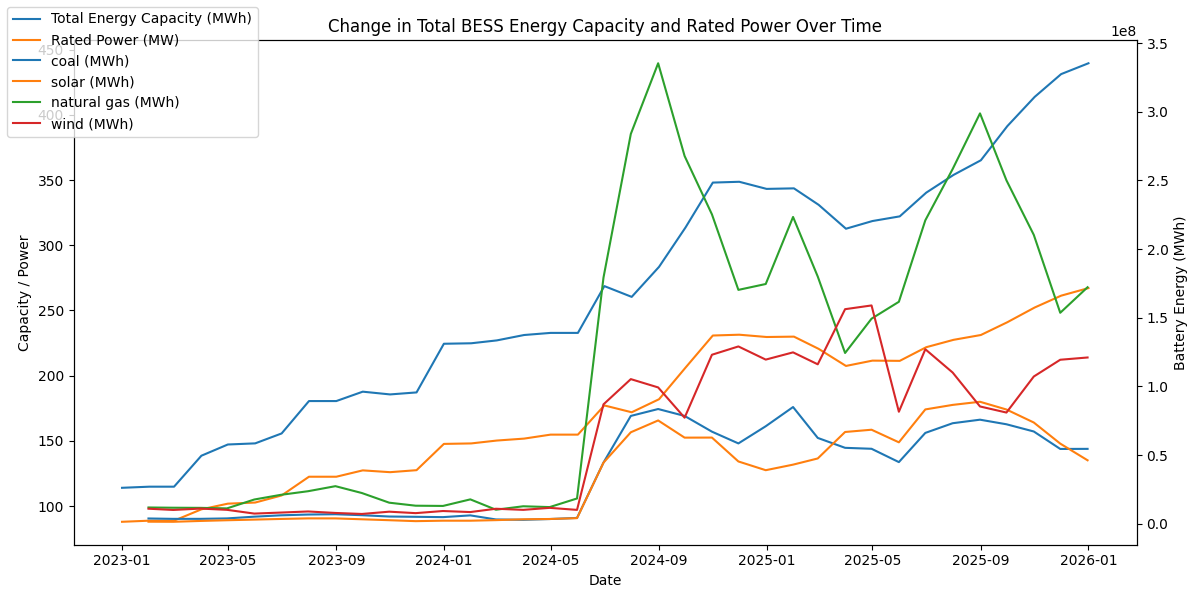

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(
    ercot_bess_monthly["month"],
    ercot_bess_monthly["total_energy_capacity_mwh"],
    label="Total Energy Capacity (MWh)",
    # color="tab:blue",
)
ax1.plot(
    ercot_bess_monthly["month"],
    ercot_bess_monthly["total_rated_power_mw"],
    label="Rated Power (MW)",
    # color="tab:orange",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Capacity / Power")
ax1.set_title("Change in Total BESS Energy Capacity and Rated Power Over Time")
ax2 = ax1.twinx()
ax2.plot(
    fuel_mix_monthly.index,
    fuel_mix_monthly["coalAndLignite"],
    label="coal (MWh)",
    # color="black",
)

ax2.plot(
    fuel_mix_monthly.index,
    fuel_mix_monthly["solar"],
    label="solar (MWh)",
    #  color="yellow",
)

ax2.plot(
    fuel_mix_monthly.index,
    fuel_mix_monthly["naturalGas"],
    label="natural gas (MWh)",
    # color="yellow",
)
ax2.plot(
    fuel_mix_monthly.index,
    fuel_mix_monthly["wind"],
    label="wind (MWh)",
    # color="yellow",
)

ax2.set_ylabel("Battery Energy (MWh)")
fig.tight_layout()
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.show()